# Land use / Land cover classification with Deep Learning (Resnet50)

Author: Vaasudevan Srinivasan  
Date: Oct 03, 2019  
Reference: [Medium post](https://towardsdatascience.com/land-use-land-cover-classification-with-deep-learning-9a5041095ddb) | [ipynb notebook](https://github.com/shakasom/Deep-Learning-for-Satellite-Imagery/blob/master/LULC_Final.ipynb)  
Datasets: [Website](http://madm.dfki.de/downloads) | [Link](madm.dfki.de/files/sentinel/EuroSATallBands.zip)

<img src="https://miro.medium.com/max/525/0*DgFhsfqk2mFeolF4.png" width=375 height=300>

# Download the Datasets


In [0]:
%%bash

wget "madm.dfki.de/files/sentinel/EuroSATallBands.zip" -qq
unzip -qq EuroSATallBands.zip
du -sh ds

2.8G	ds


# Resnet50 using Keras 

In [0]:
# Importing the modules
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import rasterio
import os

# Disable all tensorflow warnings and errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Disable deprecation warnings
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Plotting within the notebook
%matplotlib inline

In [0]:
# Config Variables

DATA_DIR = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif'
MODEL_NAME = 'LuLc_epoch30.h5'

# Get the classes
CLASSES = sorted(os.listdir(DATA_DIR))
enum_classes = dict(enumerate(CLASSES))

# Specify the shape and bands chosen for this model (B, G, R)
SHAPE = (64, 64, 3)
BANDS = (2, 3, 4)

# Training samples
training_samples = {}
for cls in CLASSES:
    sub_dir = os.path.join(DATA_DIR, cls)
    training_samples[cls] = len(os.listdir(sub_dir))

# Total training samples
NO_OF_SAMPLES = sum(training_samples.values())

# Print stats
print(enum_classes)
print(training_samples)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
{'AnnualCrop': 3000, 'Forest': 3000, 'HerbaceousVegetation': 3000, 'Highway': 2500, 'Industrial': 2500, 'Pasture': 2000, 'PermanentCrop': 2500, 'Residential': 3000, 'River': 2500, 'SeaLake': 3000}


In [0]:
# Read all the images with the specified bands
x_train = []
for cls in CLASSES:
    print("Reading data:", cls)
    sub_dir = os.path.join(DATA_DIR, cls)
    for img in os.listdir(sub_dir):
        img_data = rasterio.open(os.path.join(sub_dir, img)).read(BANDS)
        x_train.append(img_data)

# x_train using numpy stacking
x_train = np.stack(x_train).reshape((NO_OF_SAMPLES, *SHAPE))

# y_train array
indv_samples_count = enumerate(training_samples.values())
y_train = np.concatenate([[x] * val for x, val in indv_samples_count])

# Print stats
print(x_train.shape, y_train.shape)

Reading data: AnnualCrop
Reading data: Forest
Reading data: HerbaceousVegetation
Reading data: Highway
Reading data: Industrial
Reading data: Pasture
Reading data: PermanentCrop
Reading data: Residential
Reading data: River
Reading data: SeaLake
(27000, 64, 64, 3) (27000,)


In [0]:
# ResNet50 model

# Set the input image tensor shape
image_input = tf.keras.layers.Input(shape=SHAPE)

ResNet50_model = ResNet50(include_top=False,
                          weights=None,
                          input_tensor=image_input,
                          input_shape=SHAPE,
                          pooling='max')

ResNet50_output = ResNet50_model.output

predictions = tf.keras.layers.Dense(units=len(CLASSES),
                                    activation='softmax')(ResNet50_output)

model = tf.keras.models.Model(inputs=ResNet50_model.input,
                              outputs=predictions)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
# Fit the model with the sentinel data and save the model
model.fit(x_train, y_train, batch_size=500, epochs=50)
model.save(MODEL_NAME)

Train on 27000 samples
Epoch 1/50
27000/27000 [==============================] - 2149s 80ms/sample - loss: 1.6505 - accuracy: 0.5249
Epoch 2/50
27000/27000 [==============================] - 2072s 77ms/sample - loss: 0.7806 - accuracy: 0.7236
Epoch 3/50
27000/27000 [==============================] - 2064s 76ms/sample - loss: 0.5887 - accuracy: 0.7901
Epoch 4/50
27000/27000 [==============================] - 2058s 76ms/sample - loss: 0.4965 - accuracy: 0.8200
Epoch 5/50
27000/27000 [==============================] - 2059s 76ms/sample - loss: 0.4315 - accuracy: 0.8453
Epoch 6/50
27000/27000 [==============================] - 2055s 76ms/sample - loss: 0.3704 - accuracy: 0.8668
Epoch 7/50
27000/27000 [==============================] - 2057s 76ms/sample - loss: 0.3464 - accuracy: 0.8753
Epoch 8/50
27000/27000 [==============================] - 2057s 76ms/sample - loss: 0.3377 - accuracy: 0.8791
Epoch 9/50
27000/27000 [==============================] - 2057s 76ms/sample - loss: 0.2799 - accu

In [0]:
# Fit the model with the sentinel data and save the model
model.fit(x_train, y_train, batch_size=500, epochs=30)
model.save(MODEL_NAME)

Train on 27000 samples
Epoch 1/30
27000/27000 [==============================] - 2123s 79ms/sample - loss: 1.7949 - accuracy: 0.4914
Epoch 2/30
27000/27000 [==============================] - 2082s 77ms/sample - loss: 0.7430 - accuracy: 0.7348
Epoch 3/30
27000/27000 [==============================] - 2073s 77ms/sample - loss: 0.5888 - accuracy: 0.7894
Epoch 4/30
27000/27000 [==============================] - 2094s 78ms/sample - loss: 0.5667 - accuracy: 0.7982
Epoch 5/30
27000/27000 [==============================] - 2071s 77ms/sample - loss: 0.4825 - accuracy: 0.8254
Epoch 6/30
27000/27000 [==============================] - 2073s 77ms/sample - loss: 0.3781 - accuracy: 0.8649
Epoch 7/30
27000/27000 [==============================] - 2080s 77ms/sample - loss: 0.3289 - accuracy: 0.8825
Epoch 8/30
27000/27000 [==============================] - 2076s 77ms/sample - loss: 0.2831 - accuracy: 0.9000
Epoch 9/30
27000/27000 [==============================] - 2148s 80ms/sample - loss: 0.2564 - accu

# Loading and Testing the model

In [0]:
# Install the rasterio module quietly
! pip install rasterio -q

import tensorflow as tf
import rasterio

# Load the model
loaded_model = tf.keras.models.load_model("LuLc.h5")

# Classes in the model
classes = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 
           3: 'Highway', 4: 'Industrial', 5: 'Pasture', 
           6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}

Industrial Industrial


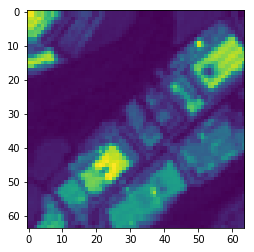

In [0]:
def predict(no):
    
    img = x_train[no]
    
    # Predict
    predicted = loaded_model.predict(img.reshape(1, 64, 64, 3))
    print(classes[predicted.argmax()], classes[y_train[no]])
    
    # Show the plot
    plt.imshow(img.reshape(3, 64, 64)[0])


predict(12345)

# Testing - Fredericton tile (64 X 64 tiles)

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import rasterio

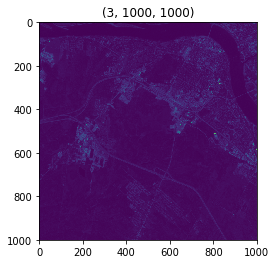

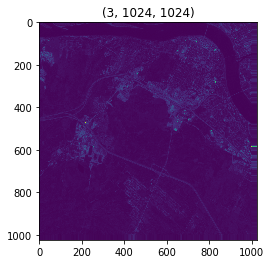

In [0]:
# Before padding
test_img = rasterio.open("13Bands_Cropped.tif").read((2, 3, 4))
plt.title(test_img.shape)
plt.imshow(test_img[0])
plt.show()

# After padding
test_img = np.pad(test_img, ((0, 0), (0, 24), (0, 24)), mode="edge")
plt.title(test_img.shape)
plt.imshow(test_img[0])
plt.show()

In [0]:
# Generate tile Indexes
row = col = list(zip(range(0, 1025, 64), range(0, 1025, 64)[1:]))
tiles = [(i, j) for i in row for j in col]
print(tiles[:25])

[((0, 64), (0, 64)), ((0, 64), (64, 128)), ((0, 64), (128, 192)), ((0, 64), (192, 256)), ((0, 64), (256, 320)), ((0, 64), (320, 384)), ((0, 64), (384, 448)), ((0, 64), (448, 512)), ((0, 64), (512, 576)), ((0, 64), (576, 640)), ((0, 64), (640, 704)), ((0, 64), (704, 768)), ((0, 64), (768, 832)), ((0, 64), (832, 896)), ((0, 64), (896, 960)), ((0, 64), (960, 1024)), ((64, 128), (0, 64)), ((64, 128), (64, 128)), ((64, 128), (128, 192)), ((64, 128), (192, 256)), ((64, 128), (256, 320)), ((64, 128), (320, 384)), ((64, 128), (384, 448)), ((64, 128), (448, 512)), ((64, 128), (512, 576))]


In [0]:
# Load the model
LuLcModel = tf.keras.models.load_model("LuLc_epoch30_97.h5")

# Classes in the model
classes = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 
           3: 'Highway', 4: 'Industrial', 5: 'Pasture', 
           6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}

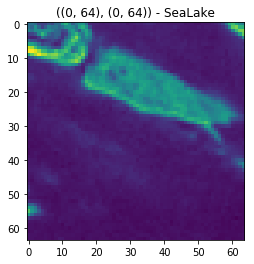

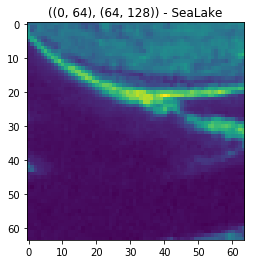

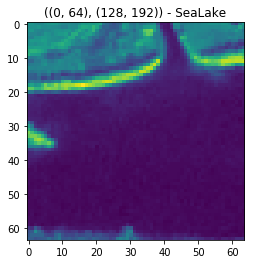

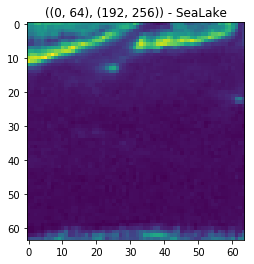

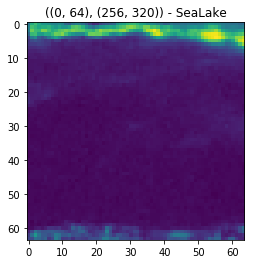

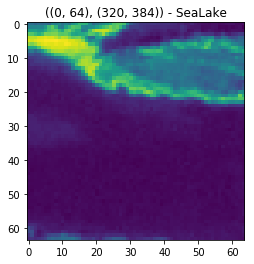

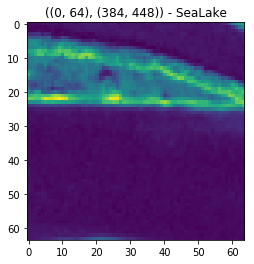

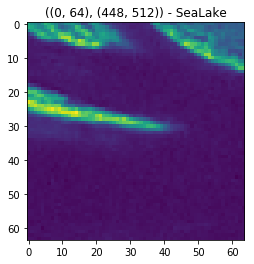

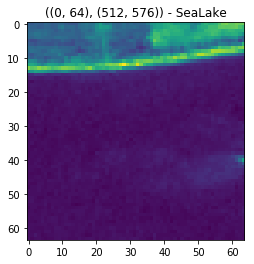

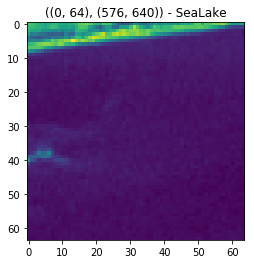

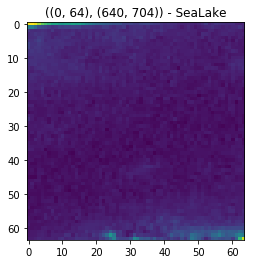

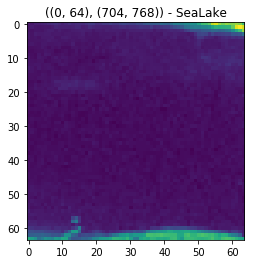

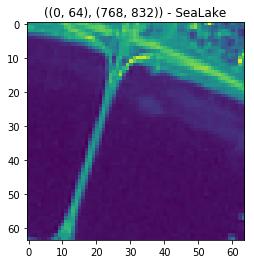

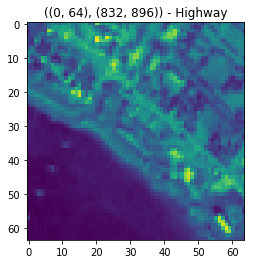

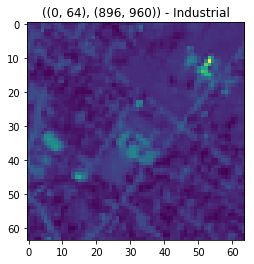

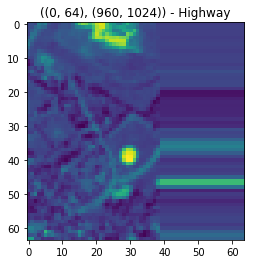

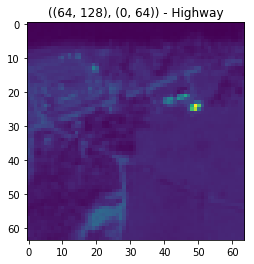

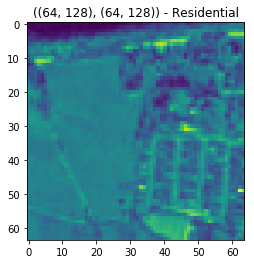

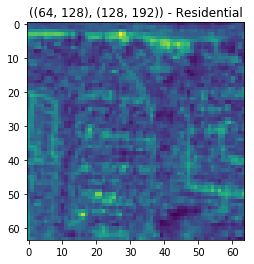

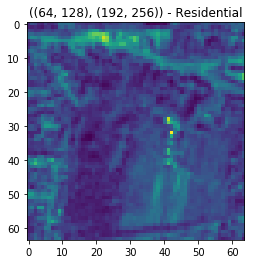

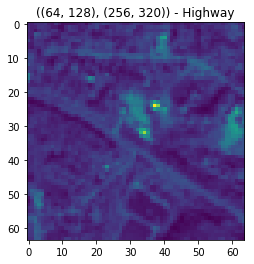

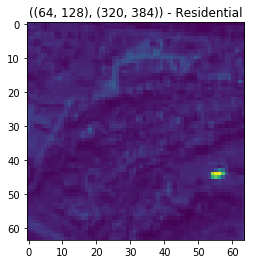

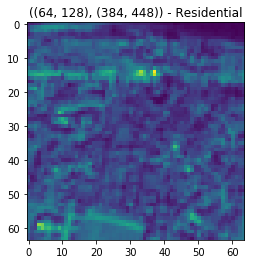

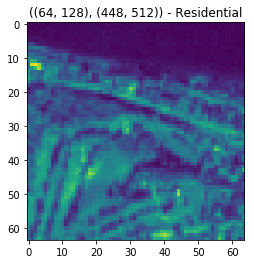

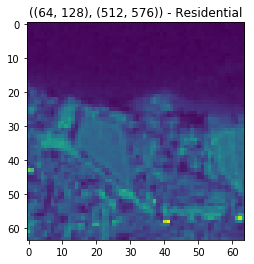

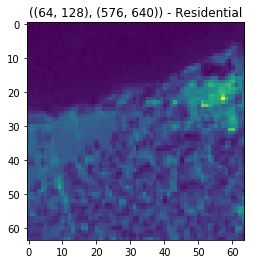

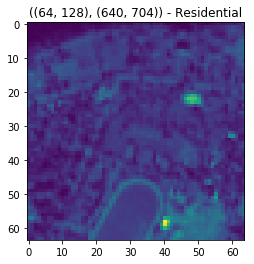

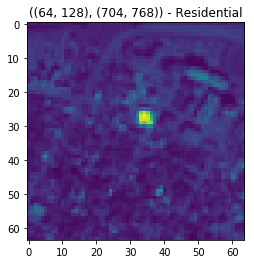

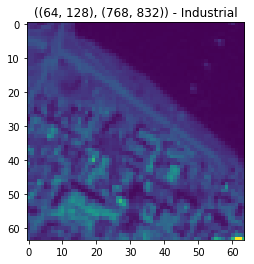

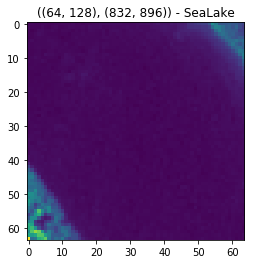

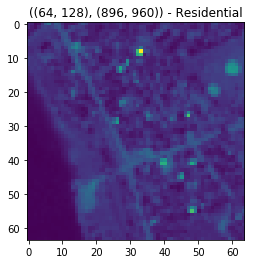

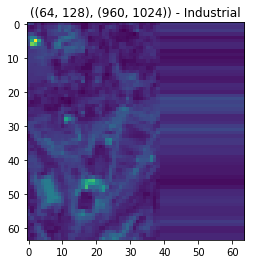

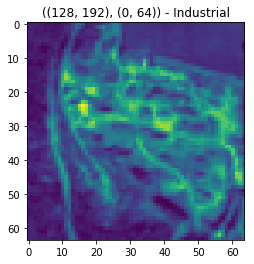

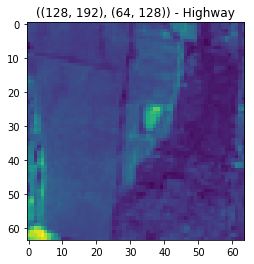

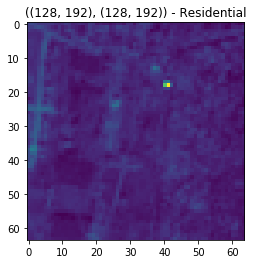

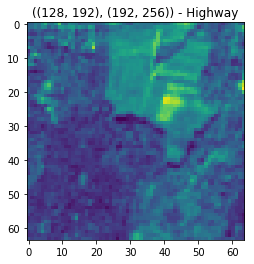

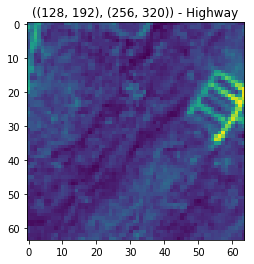

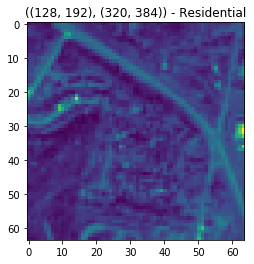

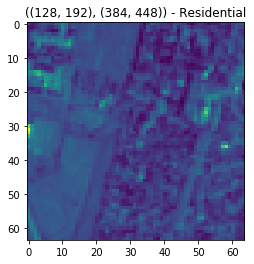

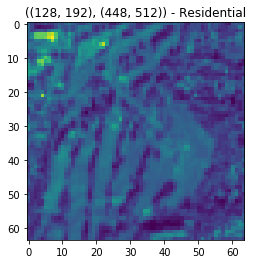

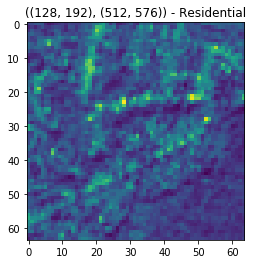

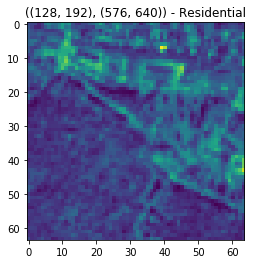

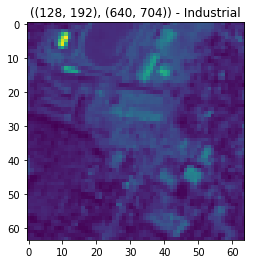

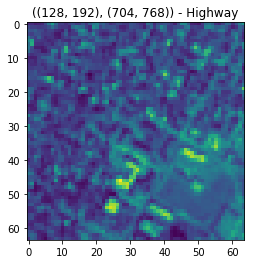

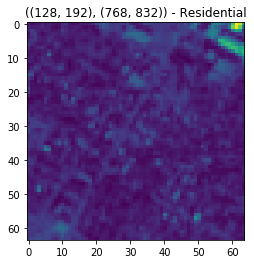

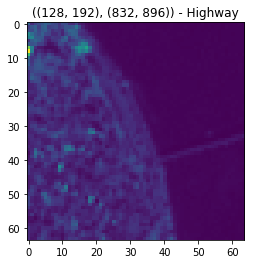

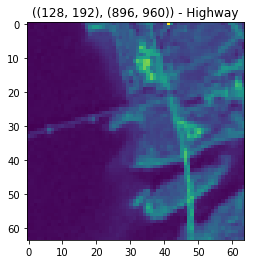

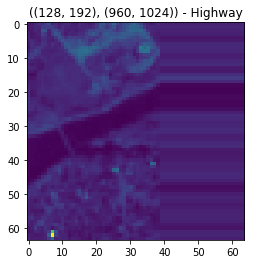

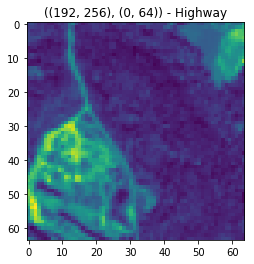

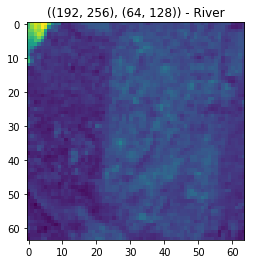

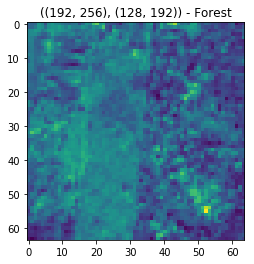

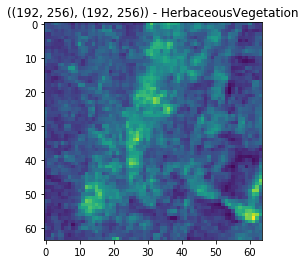

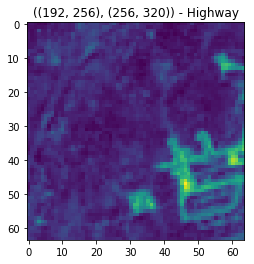

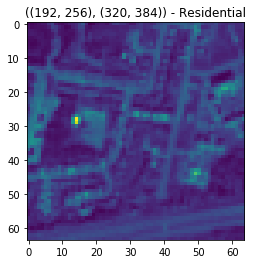

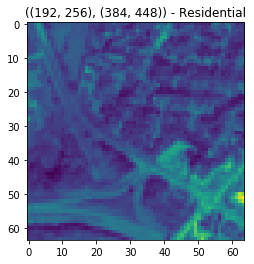

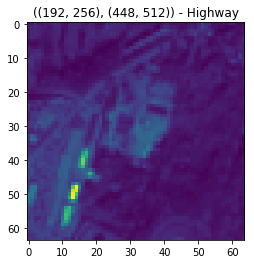

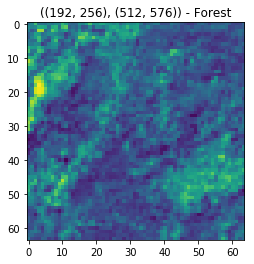

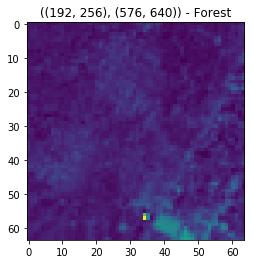

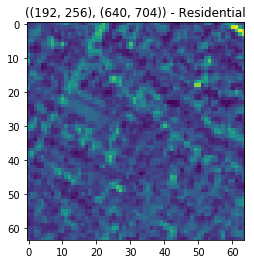

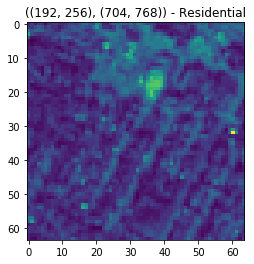

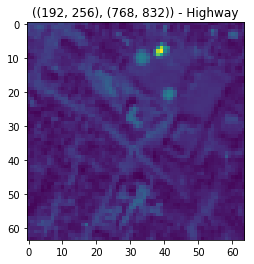

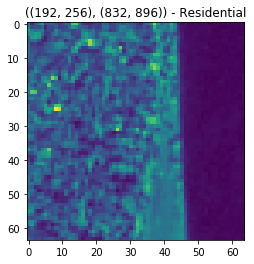

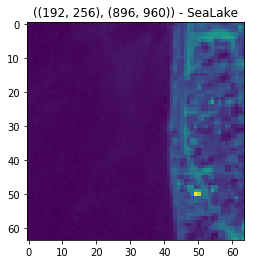

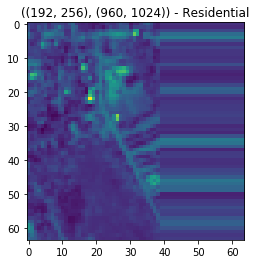

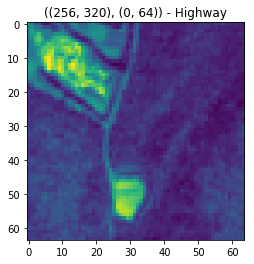

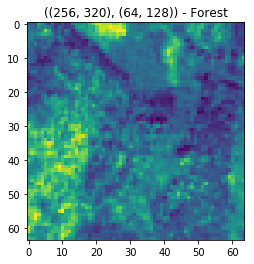

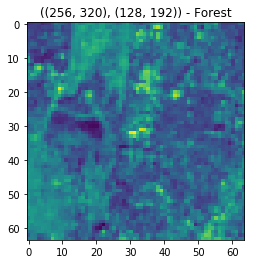

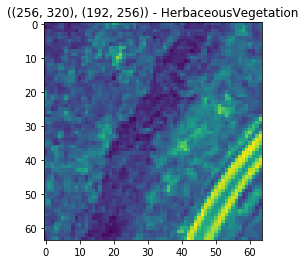

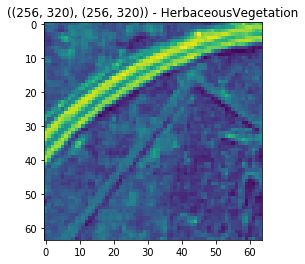

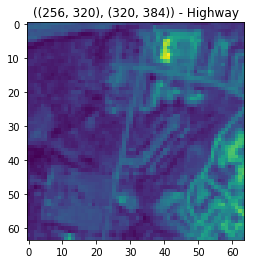

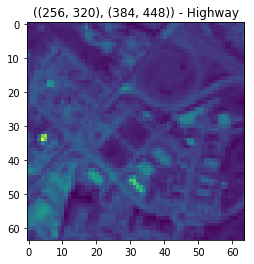

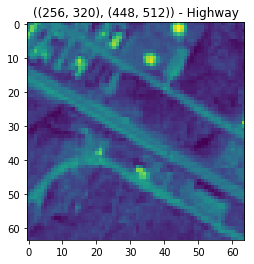

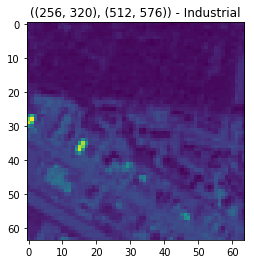

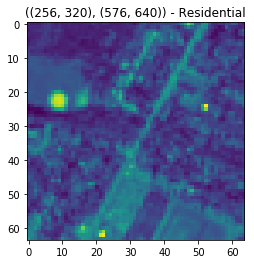

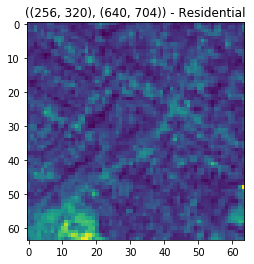

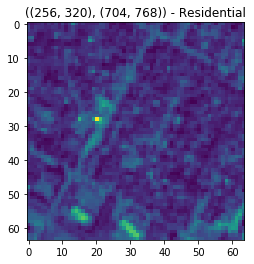

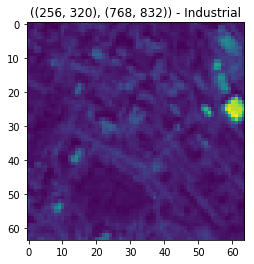

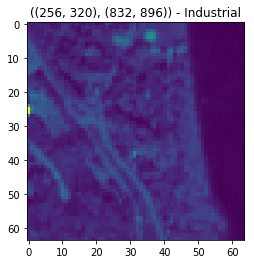

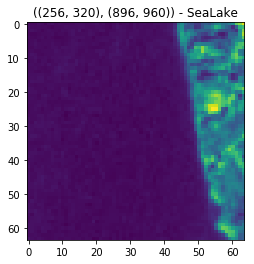

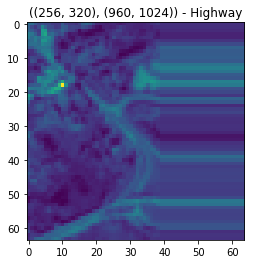

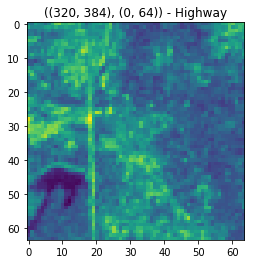

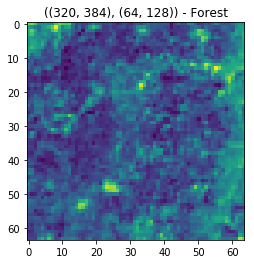

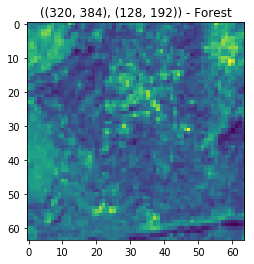

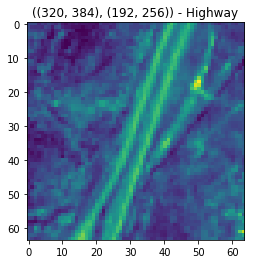

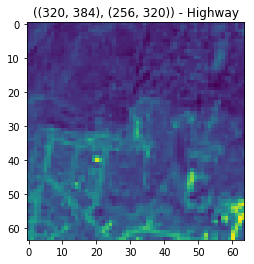

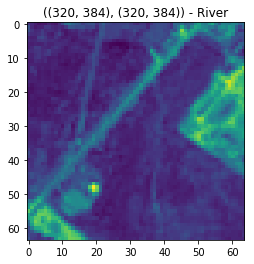

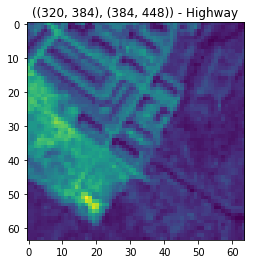

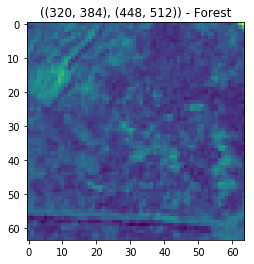

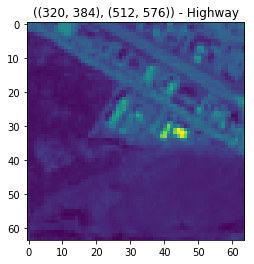

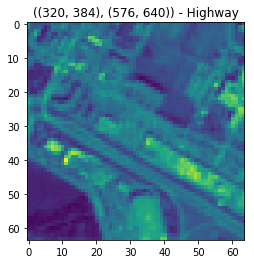

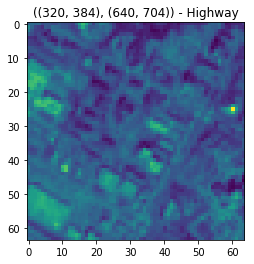

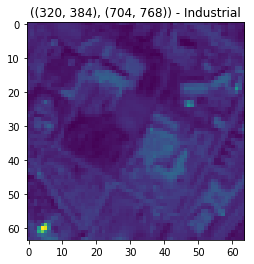

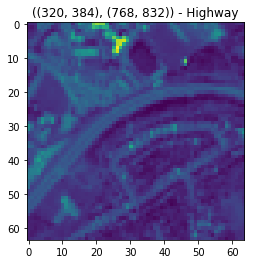

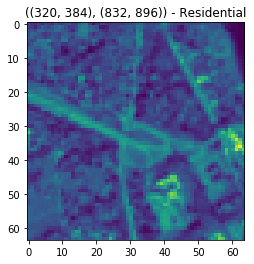

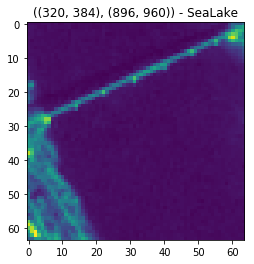

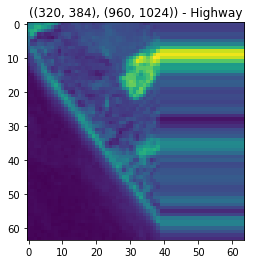

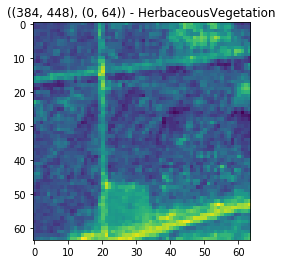

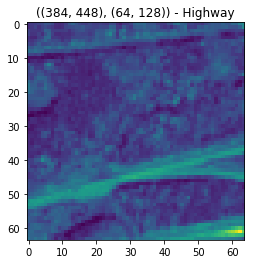

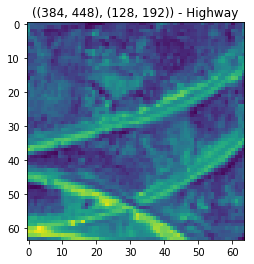

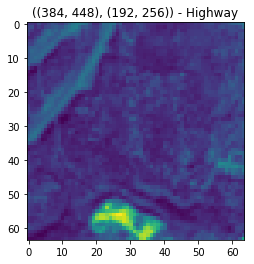

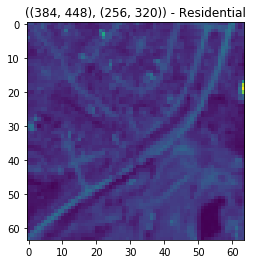

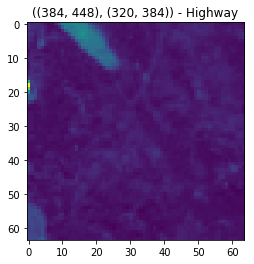

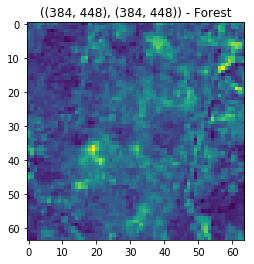

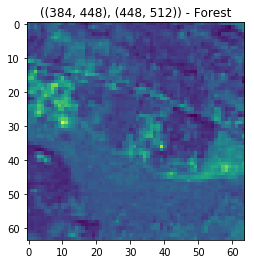

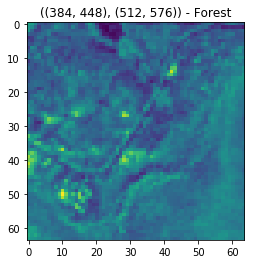

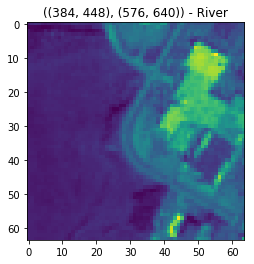

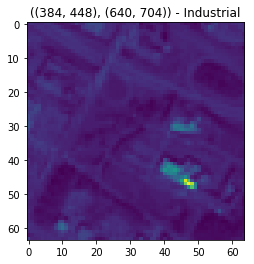

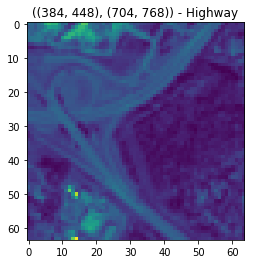

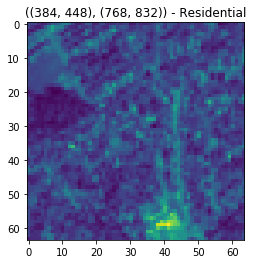

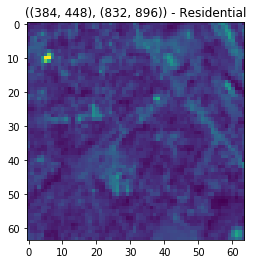

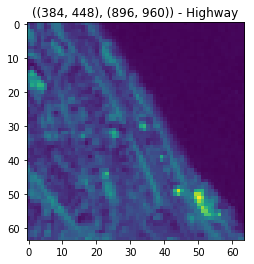

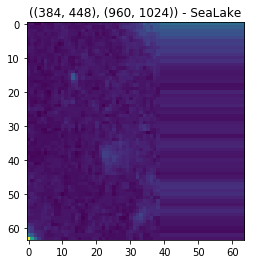

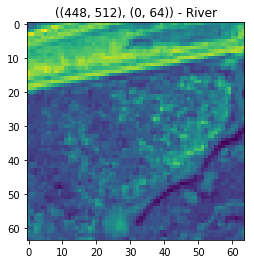

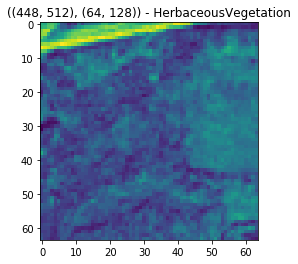

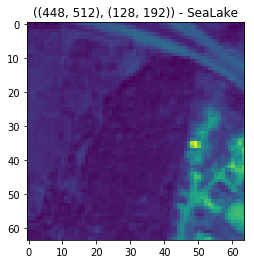

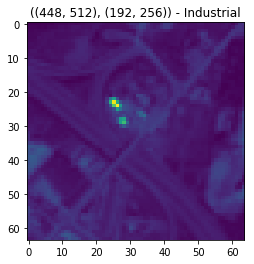

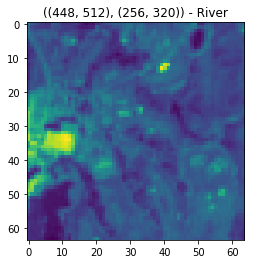

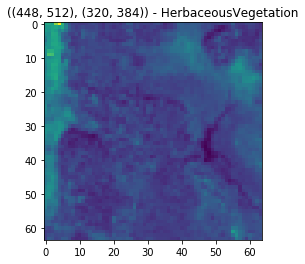

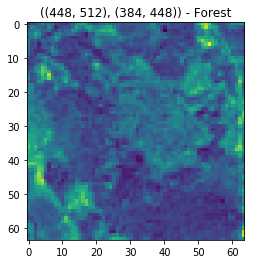

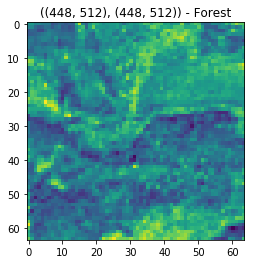

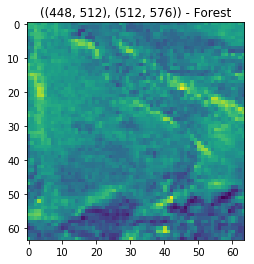

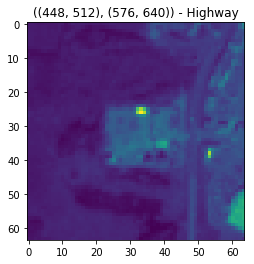

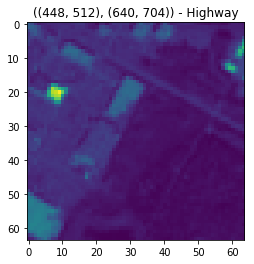

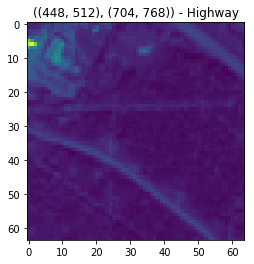

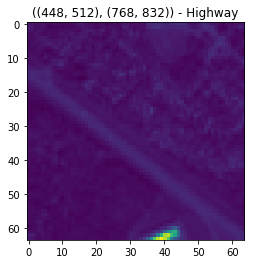

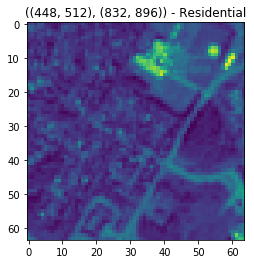

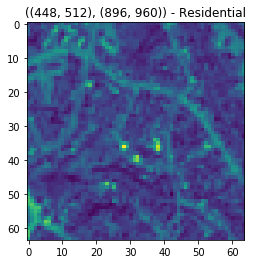

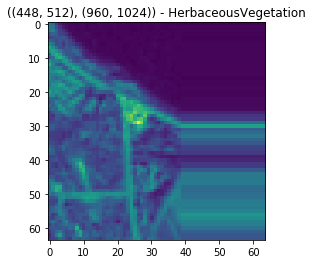

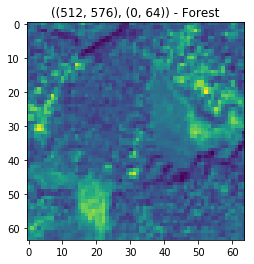

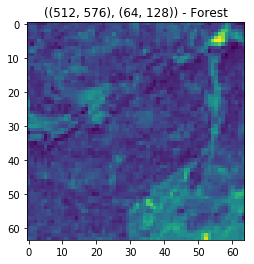

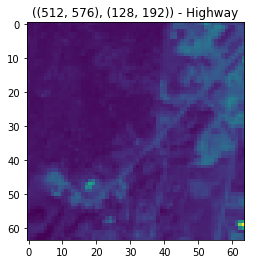

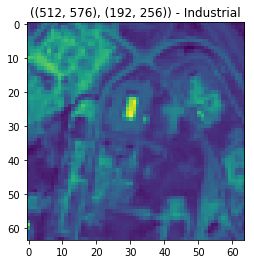

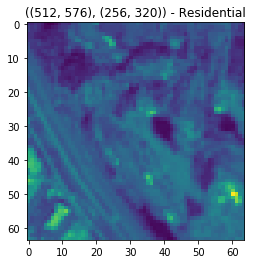

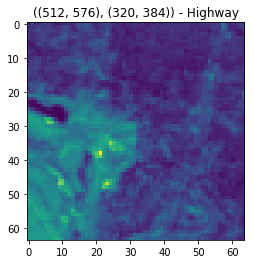

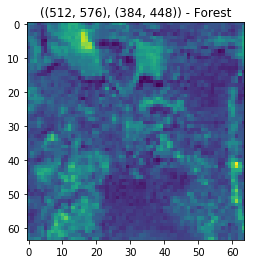

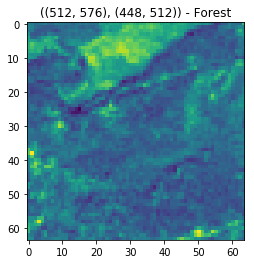

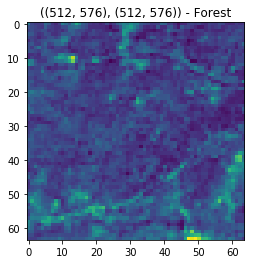

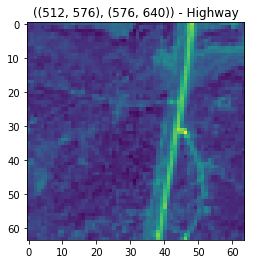

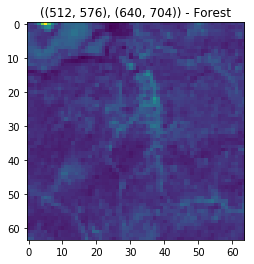

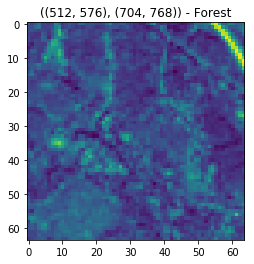

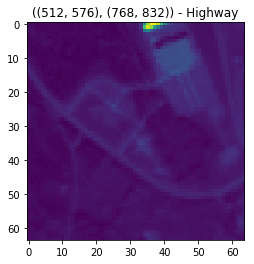

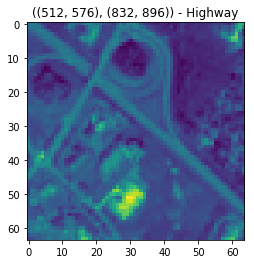

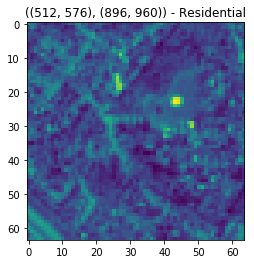

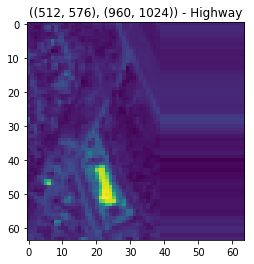

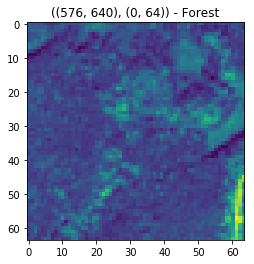

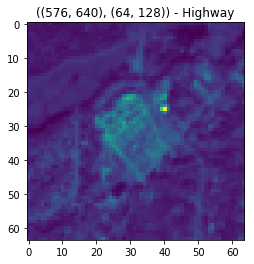

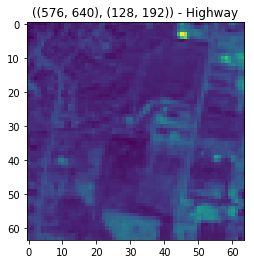

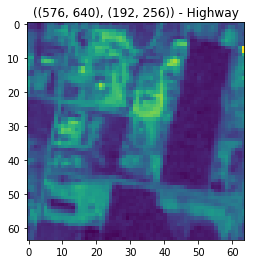

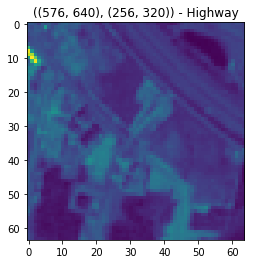

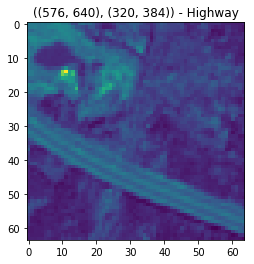

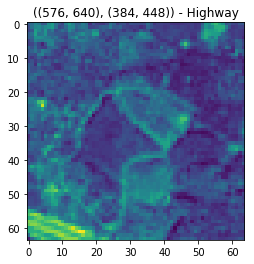

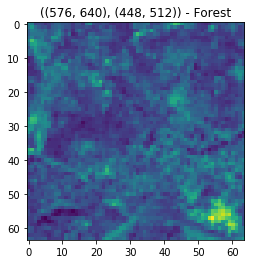

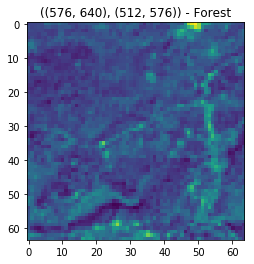

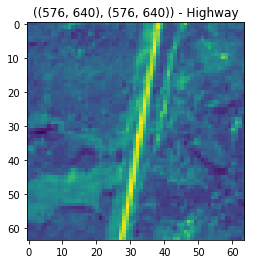

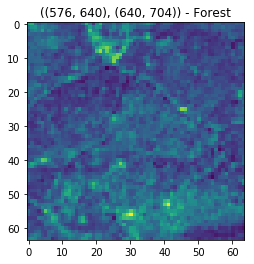

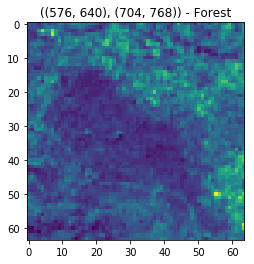

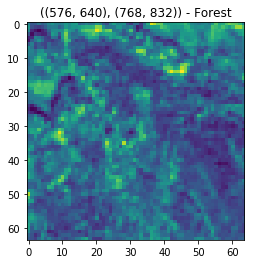

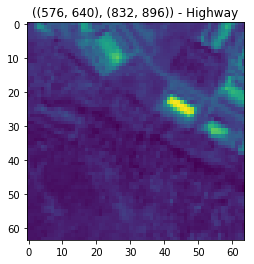

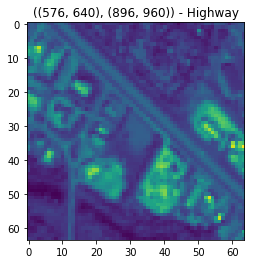

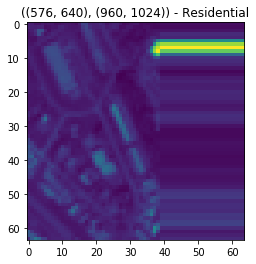

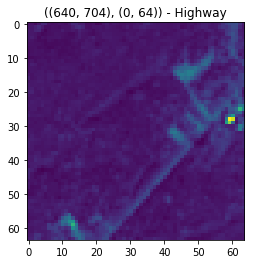

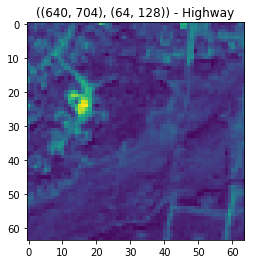

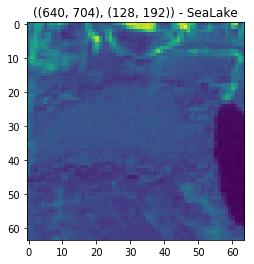

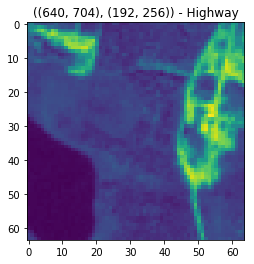

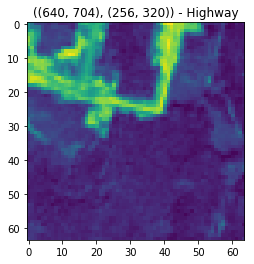

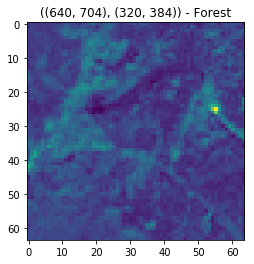

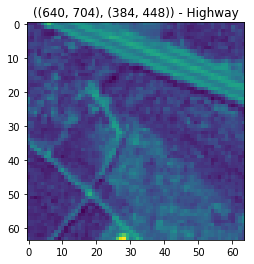

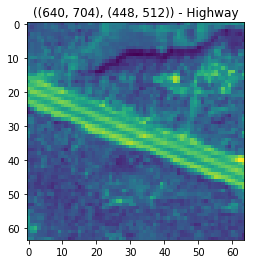

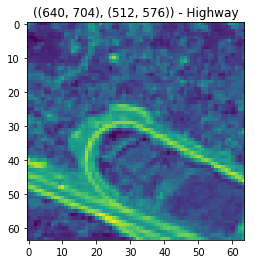

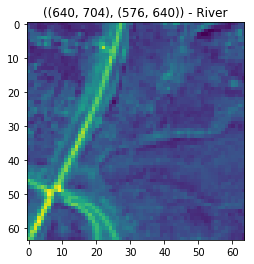

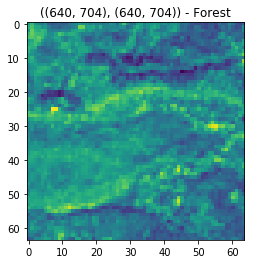

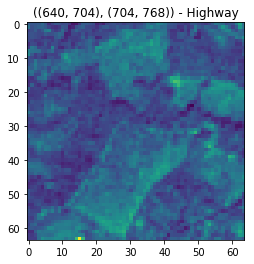

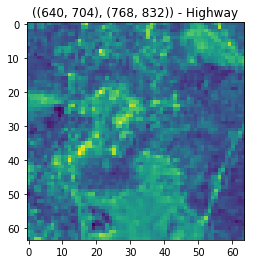

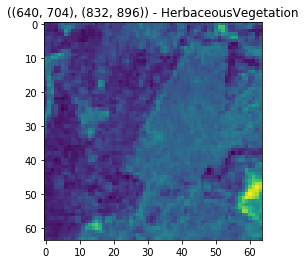

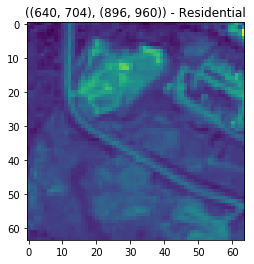

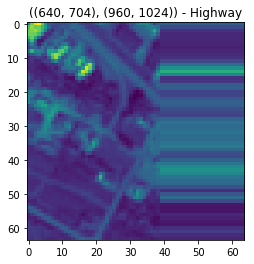

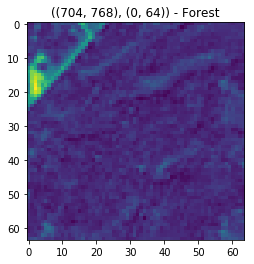

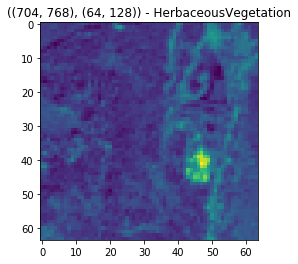

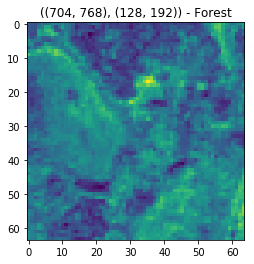

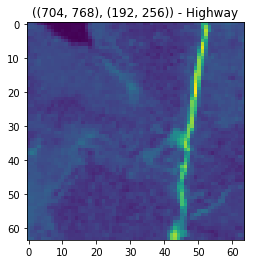

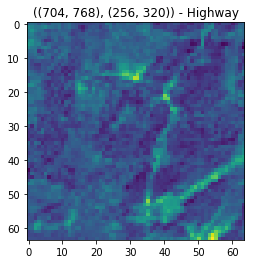

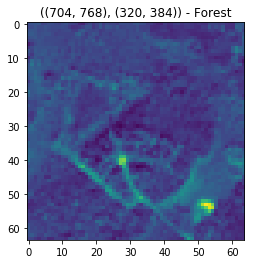

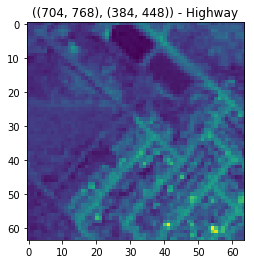

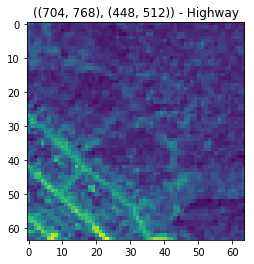

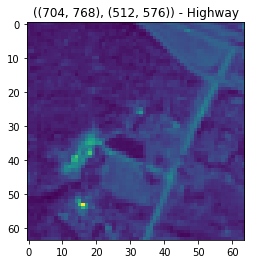

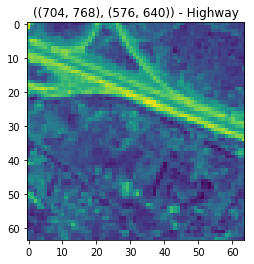

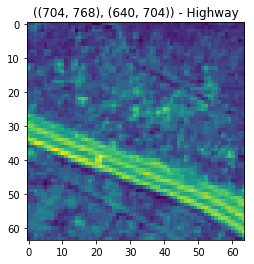

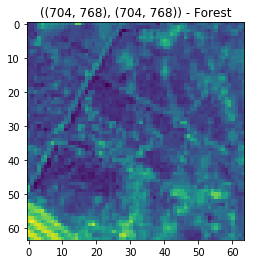

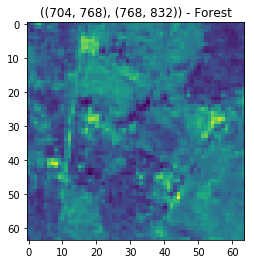

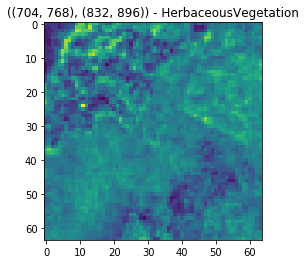

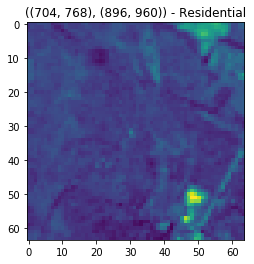

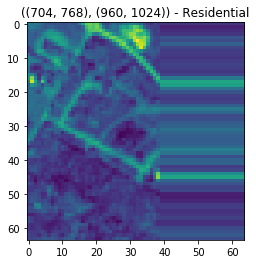

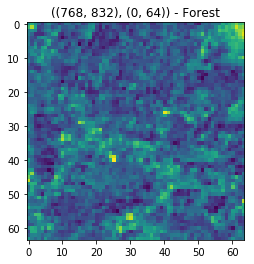

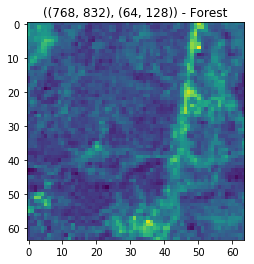

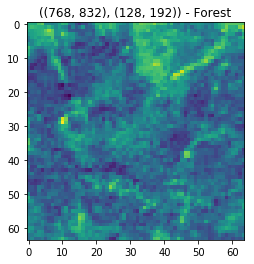

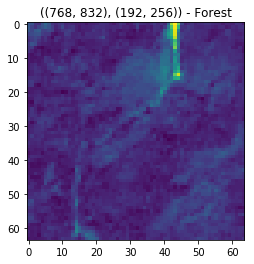

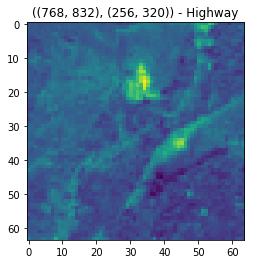

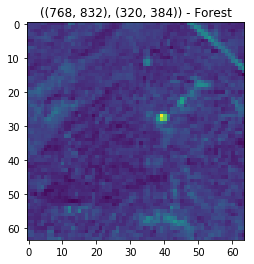

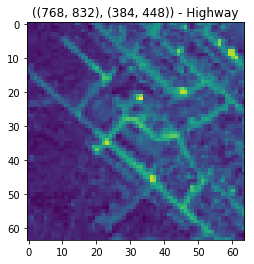

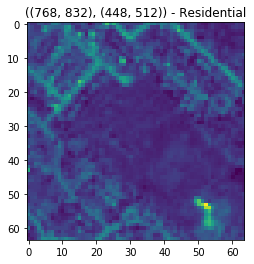

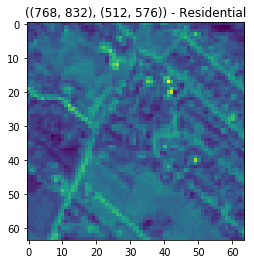

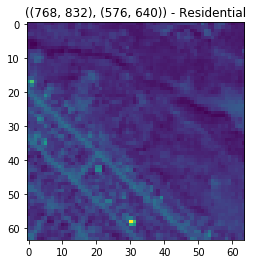

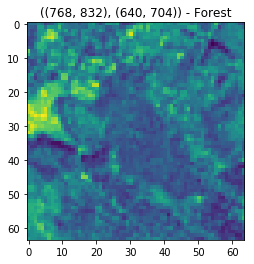

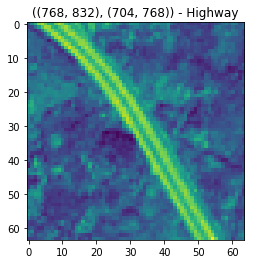

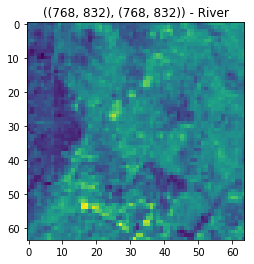

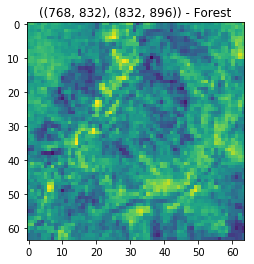

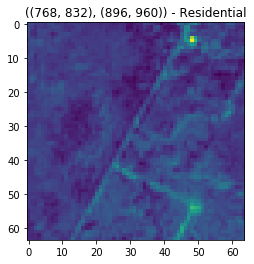

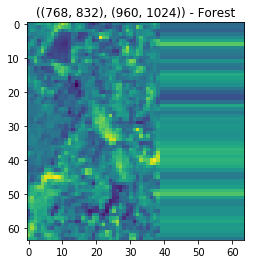

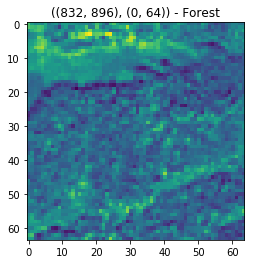

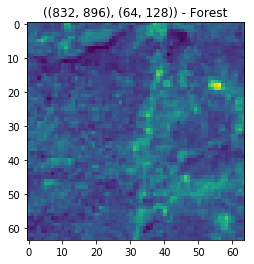

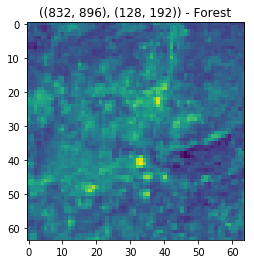

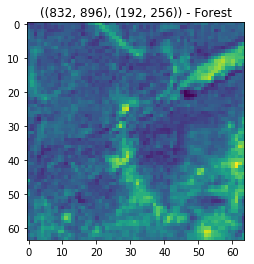

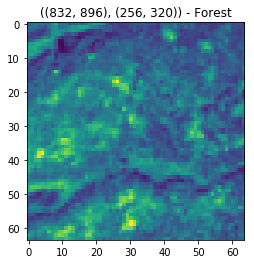

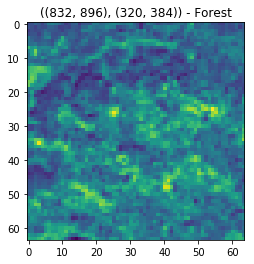

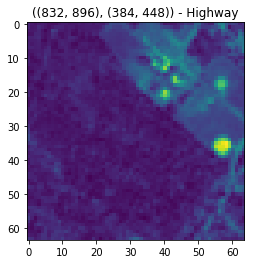

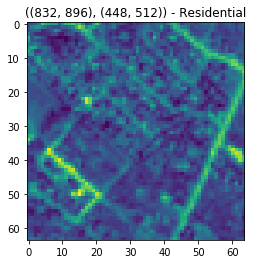

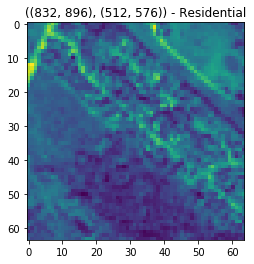

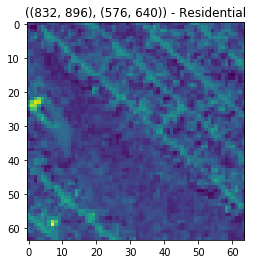

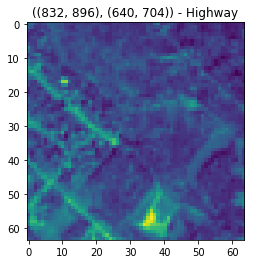

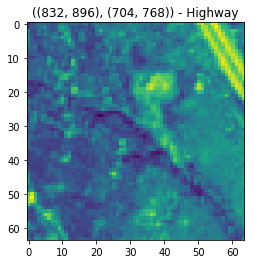

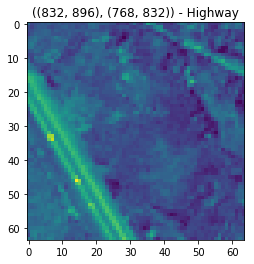

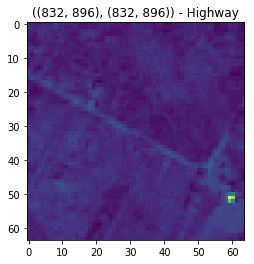

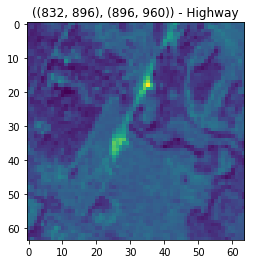

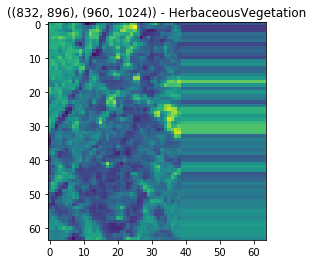

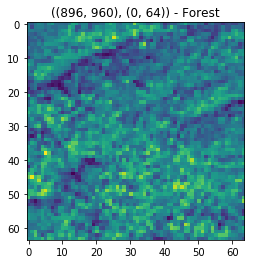

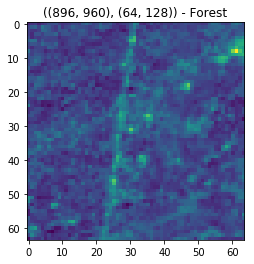

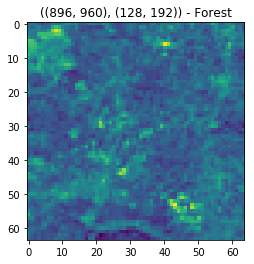

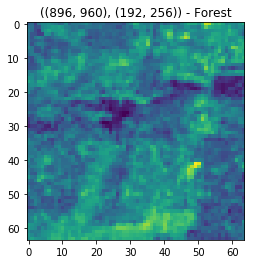

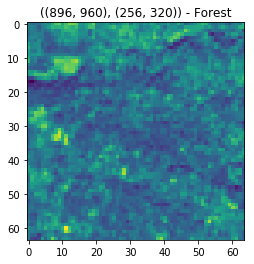

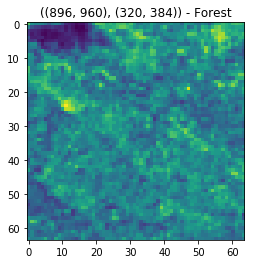

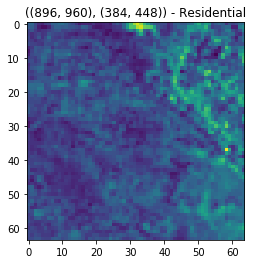

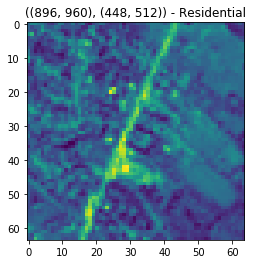

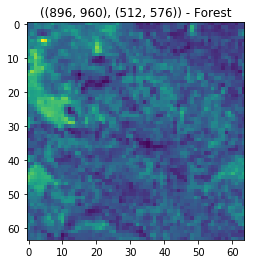

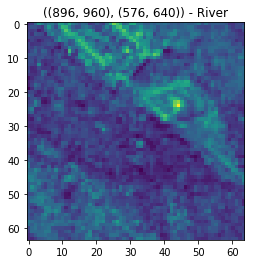

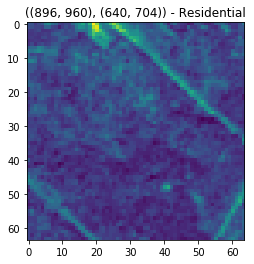

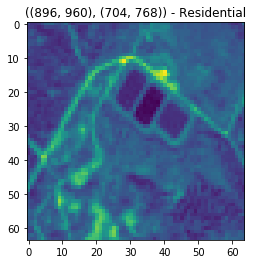

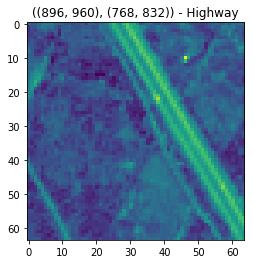

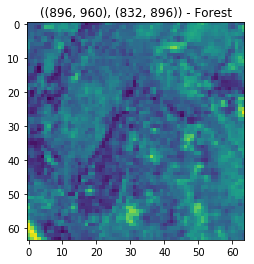

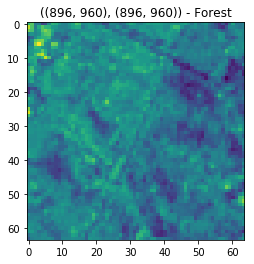

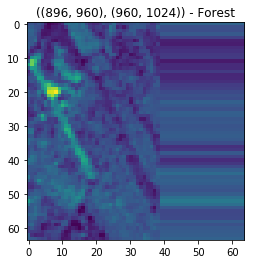

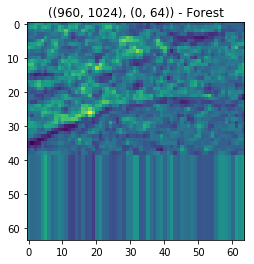

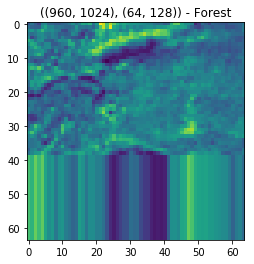

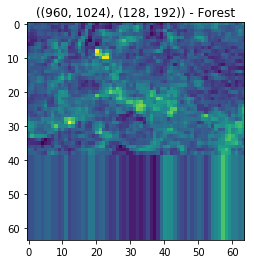

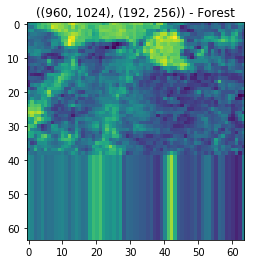

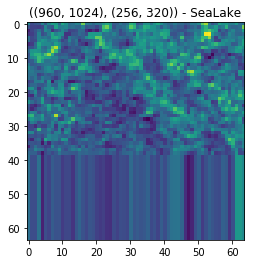

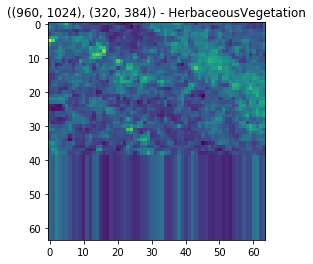

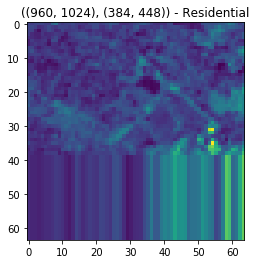

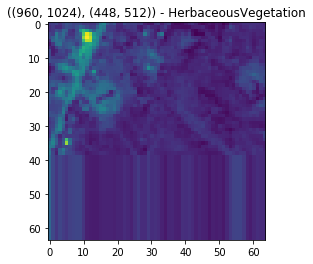

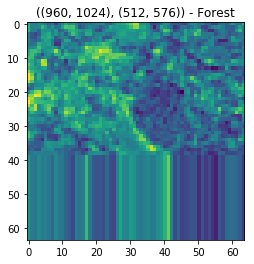

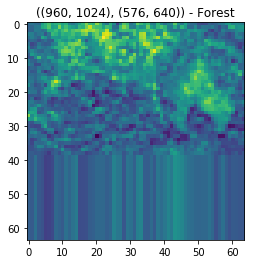

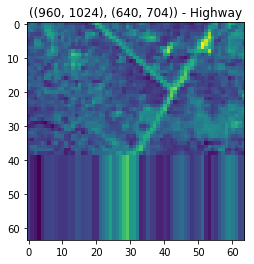

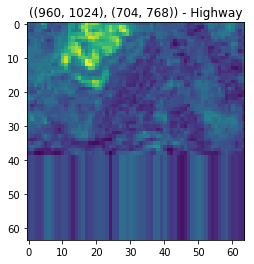

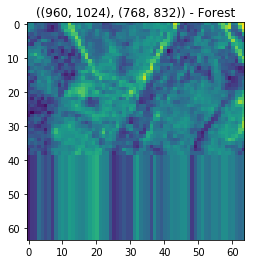

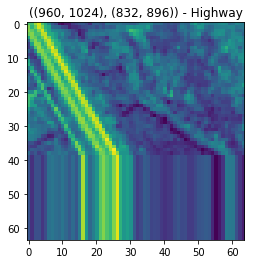

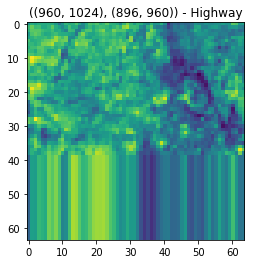

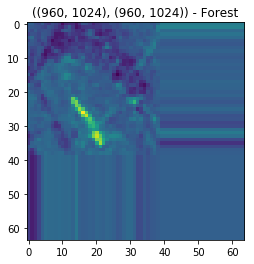

In [0]:
for tile in tiles:
    
    tile_img = test_img[:, tile[0][0]:tile[0][1], tile[1][0]:tile[1][1]]
    plt.imshow(tile_img[1])
    
    predicted = LuLcModel.predict(tile_img.reshape(1, 64, 64, 3).astype('float16'))
    plt.title(str(tile) + " - " + classes[predicted.argmax()])
    
    plt.show()